In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from pdb import set_trace as breakpoint
from time import time

import numpy as np
import matplotlib.pyplot as plt
import h5py

from datasets.generators1d import * 
from models.utils import pbar, tensor_diff, tensor_roll

In [109]:
OMEGA = 1.215e15
MU0 = 4 * np.pi * 10**-7
EPSILON0 =  8.854187817620e-12 
SCALE = 1e-15
C = 299792458.0
L0 = 1e-6
PIXEL_SIZE = 0.05 * L0
wavelength = 2 * np.pi * C / OMEGA

## Cavity experiments

In [128]:
# perms = np.ones(65)
perms = perm_alternating_layers(s=65)
epsilons, src_x, _, _, Ez = Cavity1D(cavity_buffer=16).solve(perms, omega=OMEGA_1550)

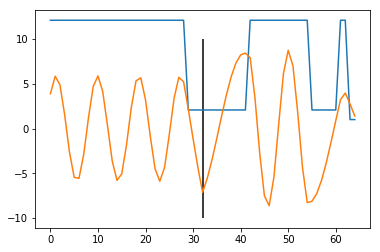

In [129]:
plt.plot(epsilons[16:-16])
plt.plot(np.imag(Ez)[16:-16], label="$E_\mathrm{true}$")
plt.vlines(src_x, -10, 10)
plt.show()


In [130]:
a = torch.tensor(np.imag(Ez)[16:-16])
roll=tensor_roll(a, 1)
dif = tensor_diff(a, n=2, cyclic=True)

dif_fill = torch.tensor([0.0]).double()
dif2 = torch.cat([dif_fill,tensor_diff(a, n=2, padding=None), dif_fill],dim=-1)
# dif2=tensor_diff(a, n=2, padding=True)

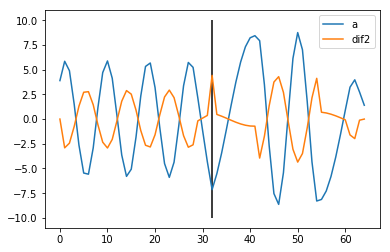

In [131]:
plt.plot(a.numpy(), label='a')
# plt.plot(roll.numpy(), label='roll')
# plt.plot(dif.numpy(), label='dif')
plt.plot(dif2.numpy(), label='dif2')
plt.vlines(src_x, -10, 10)
plt.legend()
plt.show()

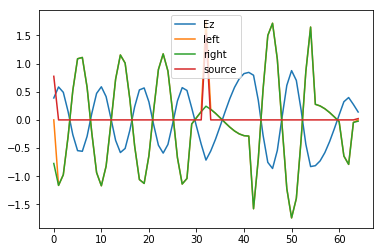

1.526814027687606


In [132]:
diffs = dif2.numpy()
ez = np.imag(Ez[16:-16])
# ez = np.real(Ez)[0:-2]
eps = epsilons[16:-16]
# eps = epsilons[2:]

x = PIXEL_SIZE * (np.arange(eps.shape[0]) - src_x)
# Check wave equation terms match
left = SCALE * diffs / PIXEL_SIZE**2
right = SCALE * -OMEGA**2 * MU0 * EPSILON0 * eps * ez
plt.plot(0.1 * ez, label="Ez")
plt.plot(left, label="left")
plt.plot(right, label="right")
# Cosine fit
# plt.plot(2 * np.cos(np.sqrt(eps) * OMEGA/C * x))
# Residual
source = left-right
plt.plot(source, label="source")
plt.legend()
plt.show()

print(np.max(left - right))

In [122]:
source

array([-3.42621317e-02, -5.86513338e-11, -8.49552095e-11, -1.07770015e-10,
       -1.26157446e-10, -1.39366879e-10, -1.46853779e-10, -1.48308782e-10,
       -1.43673962e-10, -1.33140443e-10, -1.17138577e-10, -9.63272379e-11,
       -7.15589255e-11, -4.38554540e-11, -1.43488069e-11,  1.57463244e-11,
        4.51949728e-11,  7.27885252e-11,  9.73914005e-11,  1.17998139e-10,
        1.33755479e-10,  1.44024459e-10,  1.48375340e-10,  1.46636508e-10,
        1.38875023e-10,  1.25411931e-10,  1.06798376e-10,  8.37987457e-11,
        5.73586456e-11,  2.85637000e-11, -1.40451821e-12, -3.13155890e-11,
        1.52681403e+00, -3.13153253e-11, -1.40504448e-12,  2.85636584e-11,
        5.73591313e-11,  8.37991343e-11,  1.06799500e-10,  1.25411598e-10,
        1.38874329e-10,  1.46636620e-10,  1.48377061e-10,  1.44022239e-10,
        1.33755673e-10,  1.17995835e-10,  9.73933018e-11,  7.27870958e-11,
        4.51949519e-11,  1.57464597e-11, -1.43487063e-11, -4.38552389e-11,
       -7.15602300e-11, -

In [ ]:
class Perm1dDataset_test(Dataset):
    
    def __init__(self, hdf5_file, batch_name, kernel_sizes = []):
        
        data = load_batch(hdf5_file, batch_name)
        
        self.epsilons = data["epsilons"] 
        self.src = data["src"]
        self.Ez = data["Ez"]
                
        self.input_size = self.Ez[0].shape[0]
        output_size = self.input_size
        for kernel_size in kernel_sizes:
            stride = 1
            output_size = (output_size - kernel_size) / stride + 1
        self.output_size = int(output_size)
        
    def __len__(self):
        return len(self.epsilons)

    def __getitem__(self, i):
        epsilons = torch.tensor(self.epsilons[i])
        src_x = self.src[i]
        fields = torch.tensor(np.imag(self.Ez[i])) # TODO: change to real
        return epsilons.float(), fields.float()

class Perm1dDataset(Dataset):
    
    def __init__(self, epsilon_generator, kernel_sizes = [], N=10000, size=65):
        self.size = size
        self.epsilon_generator = epsilon_generator
        self.epsilon_samples = []
        self.N = N
        self.infinite_mode = infinite_mode
        
    def __len__(self):
        if self.infinite_mode:
            return int(1e8)
        else:
            return int(self.N)

    def __getitem__(self, i):
        if i >= len(self.epsilon_samples) or self.infinite_mode:
            epsilons = torch.tensor(self.epsilon_generator()).float()
            src_x = np.random.randint(1,127-1) # 16 # TODO
            if not self.infinite_mode:
                self.epsilon_samples.append(epsilons)
            return epsilons, torch.empty_like(epsilons).float()
        else:
            epsilons = self.epsilon_samples[i]
            src_x = self.src_samples[i]
            return epsilons.float(), torch.empty_like(epsilons).float()

In [ ]:
class MaxwellDense(nn.Module):
    
    def __init__(self, size=65, src_x=32):
        super().__init__()
        
        self.size = size
        self.src_x = src_x
        src = torch.zeros(*epsilons.shape)
        src[:,src_x] = 1.526814027933079
        self.src = src
        self.layer_dims = [2 * self.size, 256, 256, 128, self.size]

        layers_amp = []
        layers_phi = []
        for i in range(len(self.layer_dims) - 1):
            layers_amp.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            layers_phi.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
            
        self.layers_amp = nn.ModuleList(layers_amp)
        self.layers_phi = nn.ModuleList(layers_phi)
        
    def forward_amplitude_phase(self, x):
        A = x
        for i, layer in enumerate(self.layers_amp):
            A = layer(A)
            if i < len(self.layers_amp) - 1:
                A = nn.ReLU()(A)
                
        phi = x
        for i, layer in enumerate(self.layers_phi):
            phi = layer(phi)
            if i < len(self.layers_amp) - 1:
                phi = nn.ReLU()(phi)
        
        return A, phi
    
    def get_fields(self, epsilons):
        # Get amplitude and phase vectors
        A, phi = self.forward_amplitude_phase(epsilons)
            
        # Combine to form waveform
        x = (PIXEL_SIZE * (torch.arange(self.size) - self.src_x)).float()
        fields = A * torch.cos(OMEGA / C * torch.sqrt(epsilons) * x + phi)
        
        return fields
        
    def forward(self, epsilons):
        
        fields = self.get_fields(epsilons)

        eps = epsilons[:,1:-1]
        E = fields[:,1:-1]
        
        
        # Compute Maxwell operator on fields
        curl_curl_E = tensor_diff(fields, n=2)
        left_factor =  SCALE / PIXEL_SIZE**2
        right_factor = SCALE * -OMEGA**2 * MU0 * EPSILON0
        
        out = (left_factor * curl_curl_E) - (right_factor * eps * E) - self.src[:,1:-1]
        
        return out